<a href="https://colab.research.google.com/github/jeramirez169/DataScience_SGS_Classification/blob/main/models/02_classic_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Clonar tu repositorio desde GitHub
!git clone https://github.com/jeramirez169/DataScience_SGS_Classification.git
%cd DataScience_SGS_Classification

# Instalar dependencias necesarias
!pip install -q pandas numpy scikit-learn unidecode spacy imbalanced-learn transformers
!python -m spacy download es_core_news_lg


Cloning into 'DataScience_SGS_Classification'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 82 (delta 36), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 23.95 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/DataScience_SGS_Classification/DataScience_SGS_Classification/DataScience_SGS_Classification
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 837.7 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [39]:
# Ir a la carpeta data
%cd data

# Descomprimir el archivo ZIP
!unzip "Dataset_SGS_clean.zip" -d .

# Regresar al directorio raíz del proyecto
%cd ..


/content/DataScience_SGS_Classification/DataScience_SGS_Classification/DataScience_SGS_Classification/data
Archive:  Dataset_SGS_clean.zip
  inflating: ./Dataset_SGS_clean.csv  
/content/DataScience_SGS_Classification/DataScience_SGS_Classification/DataScience_SGS_Classification


Columnas del dataset: ['Oficina', 'texto_truncado', 'texto_truncado_lematizado']
Tamaño del dataset: (69746, 3)
Tamaño entrenamiento: 55796
Tamaño prueba: 13950
Forma de la matriz TF-IDF (train): (55796, 125738)

RESULTADOS SVM
                        precision    recall  f1-score   support

            Biblioteca       0.99      0.96      0.97       423
Desarrollo de sistemas       0.87      0.84      0.85      1310
       Infraestructura       0.76      0.69      0.72      1443
           Multimedios       0.99      0.99      0.99      6185
           Operaciones       0.91      0.85      0.88      3776
 Servicios y proyectos       0.59      0.88      0.71       813

              accuracy                           0.90     13950
             macro avg       0.85      0.87      0.85     13950
          weighted avg       0.91      0.90      0.90     13950



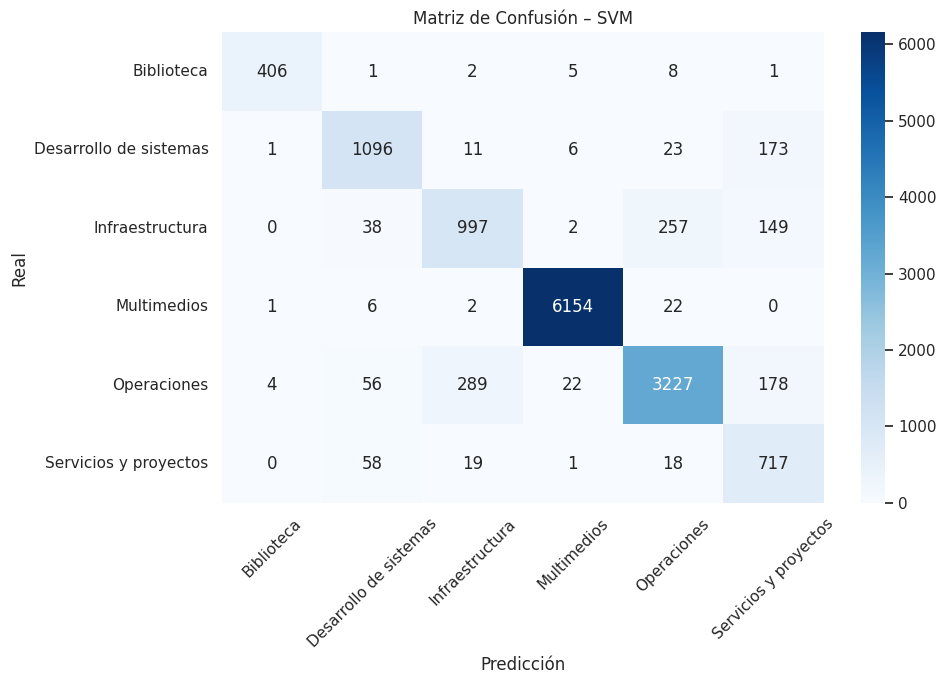


Mapeo de etiquetas (clase → código):
Biblioteca                -> 0
Desarrollo de sistemas    -> 1
Infraestructura           -> 2
Multimedios               -> 3
Operaciones               -> 4
Servicios y proyectos     -> 5

Entrenando XGBoost (puede tardar varios minutos)...

RESULTADOS XGBOOST
                        precision    recall  f1-score   support

            Biblioteca       0.99      0.93      0.96       423
Desarrollo de sistemas       0.91      0.81      0.86      1310
       Infraestructura       0.81      0.67      0.74      1443
           Multimedios       0.99      0.99      0.99      6185
           Operaciones       0.88      0.88      0.88      3776
 Servicios y proyectos       0.60      0.91      0.73       813

              accuracy                           0.91     13950
             macro avg       0.86      0.87      0.86     13950
          weighted avg       0.91      0.91      0.91     13950



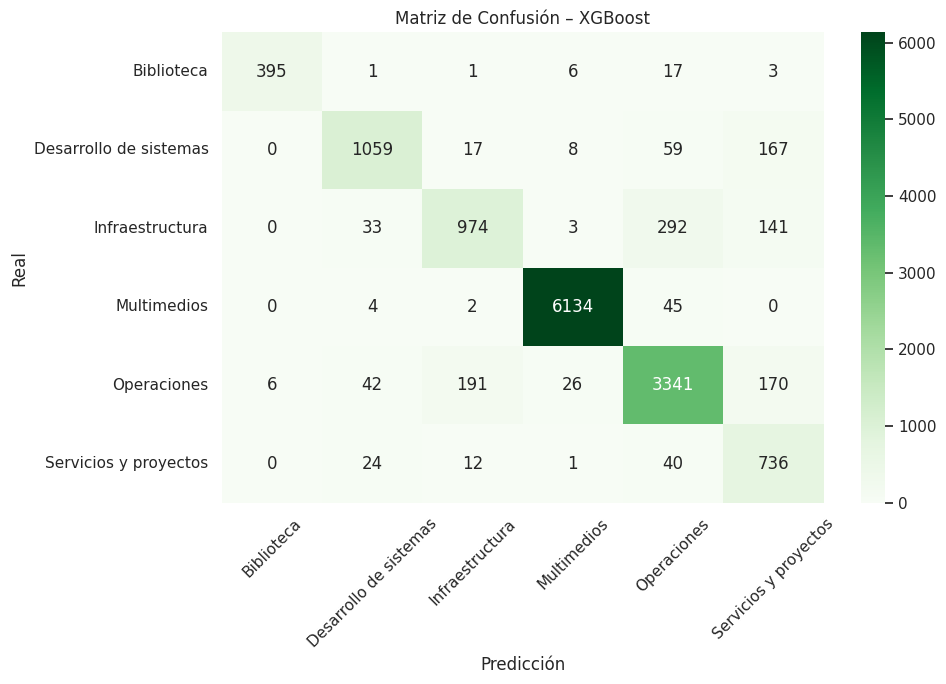

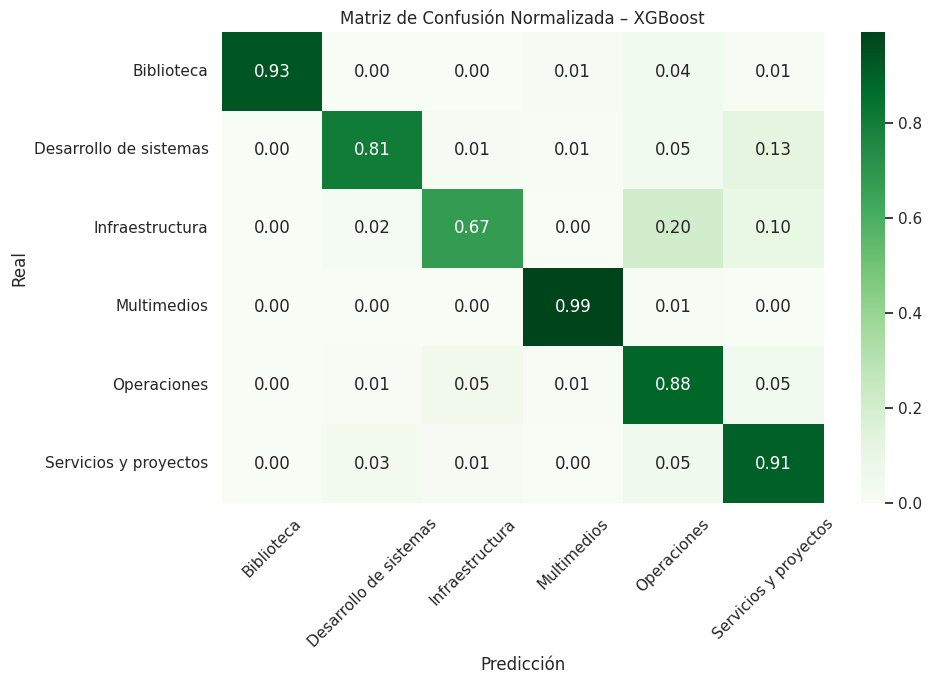


Modelos y vectorizador guardados en carpeta 'models/'.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

sns.set(style="whitegrid")

# Carga del dataset limpio
ruta = "data/Dataset_SGS_clean.csv"   # Ajusta si tu ruta es distinta
df = pd.read_csv(ruta, encoding="utf-8")

print("Columnas del dataset:", df.columns.tolist())
print("Tamaño del dataset:", df.shape)

#Definición de variables X (texto) e y (etiqueta)
X = df["texto_truncado_lematizado"]
y = df["Oficina"]

# 3. Partición Train/Test (para ambos modelos)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Tamaño entrenamiento:", X_train.shape[0])
print("Tamaño prueba:", X_test.shape[0])

#
# Vectorización TF-IDF
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Forma de la matriz TF-IDF (train):", X_train_tfidf.shape)

# MODELO SVM
svm_model = LinearSVC(
    C=1.0,
    loss="squared_hinge",
    class_weight="balanced",
    max_iter=5000,
    random_state=42
)

svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)

print("\n" + "="*60)
print("RESULTADOS SVM")
print("="*60)
print(classification_report(y_test, y_pred_svm))

# Matriz de confusión SVM
labels = sorted(y.unique())

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión – SVM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#MODELO XGBOOST

# Codificación de etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("\nMapeo de etiquetas (clase → código):")
for cls, code in zip(le.classes_, le.transform(le.classes_)):
    print(f"{cls:25s} -> {code}")

# Definición del modelo XGBoost
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=1.0,
    reg_lambda=1.0,
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42
)

print("\nEntrenando XGBoost")
xgb_model.fit(X_train_tfidf, y_train_enc)

y_pred_xgb_enc = xgb_model.predict(X_test_tfidf)
y_pred_xgb = le.inverse_transform(y_pred_xgb_enc)

print("\n" + "="*60)
print("RESULTADOS XGBOOST")
print("="*60)
print(classification_report(y_test, y_pred_xgb))

# Matriz de confusión XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión – XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Matriz de confusión normalizada XGBoost
cm_xgb_norm = cm_xgb.astype("float") / cm_xgb.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm_xgb_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión Normalizada – XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#Guardado de modelos y vectorizador
joblib.dump(tfidf, "models/tfidf_vectorizer.pkl")
joblib.dump(svm_model, "models/svm_model.pkl")
joblib.dump(xgb_model, "models/xgb_model_gpu.pkl")

print("\nModelos y vectorizador guardados en carpeta 'models/'.")
